Machine information 

In [70]:
versioninfo()

Julia Version 1.1.1
Commit 55e36cc (2019-05-16 04:10 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin15.6.0)
  CPU: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


## Demo data



For demonstration, we generate a random data set. 

In [1]:
using LinearAlgebra 

## generate data from a d-variate response variance component model
n = 100          # no. observations
d = 3            # no. categories
m = 10           # no. variance components
p = 4            # no. covariates
X = randn(n, p)  # n-by-p covariate matrix 
β = ones(p, d)   # p-by-d mean component regression coefficient 

# a vector of d-by-d variance component parameters 
Σ = [zeros(d, d) for i in 1:m]
for i in [1, 4, 10]
  Σi = randn(d, d)
  Σ[i] = Σi * Σi' 
end

# a vector of covariance matrices 
V  = Array{Matrix{Float64}}(undef, m)
for i = 1:(m - 1)
  Vi = randn(n, 50)
  V[i] =  Vi * Vi'
  V[i] ./= norm(V[i])
end
V[end] = Matrix(I, n, n) ./ √n

# form overall nd-by-nd covariance matrix Ω
Ω = zeros(n*d, n*d)
for i = 1:m
    Ω .+= kron(Σ[i], V[i])
end
Ωchol = cholesky!(Symmetric(Ω))

# n-by-d responses
Y = X * β + reshape(Ωchol.L * randn(n*d), n, d);

## Model formulation

We assume that response matrix $Y$ is distributed as 

$$Y \sim \text{Normal}(X\beta, \Sigma_1 \otimes V_1 + \cdots + \Sigma_{9}\otimes V_{9} + \Sigma_0 \otimes I_n)$$

where $\otimes$ indicates Kronecker product and each $\Sigma_i$ indicates variance component for $i$-th group, $i=1,\ldots, 9.$ Define $\Omega = \text{Var}(Y) = \sigma_1^2 V_1 + \cdots + \sigma_{9}^2V_{9} + \sigma_0^2 I_n.$

Suppose we wish to select $\Sigma_i, i=1,\ldots, 9$ that are associated with response $Y.$ This can be achieved by `VarianceComponentSelect.jl` package. 

## VCModel 

First load the package.

In [2]:
using VarianceComponentSelect 

┌ Info: Recompiling stale cache file /Users/juhyun-kim/.julia/compiled/v1.1/VarianceComponentSelect/iiLmX.ji for VarianceComponentSelect [684d1ed6-5d62-11e9-0c0b-878d753c12b1]
└ @ Base loading.jl:1184


To perform selection, take 2 steps:

**Step 1 (Construct a model)**. Construct an instance of `VCModel`, which is the fundamental type for variance component model. It consists of fields 

* `Y`: $n$-by-$d$ responses. 
* `X`: $n$-by-$p$ covariate matrix (if exists).
* `V=(V[1],...,V[m],I)`: a vector of $n$-by-$n$ covariance matrices. The last covariance matrix must be positive definite and usually is the identity matrix.
* `Σ=(Σ[1],...,Σ[m])`: a vector of initial estimates for $d$-by-$d$ variance component parameters. When $d=1$, `Σ` is a $m$-by-$1$ vector. If not supplied, it is set to be a vector of $d$-by-$d$ identity matrix by default. 

`VCModel` can be initialized by 

Let us construct a `VCModel` using `Y`, `X`, and `V`. Since we do not provide `Σ`, it is initialized to be a vector of identity matrices. 

In [3]:
vcm = VCModel(Y, X, V);

In [4]:
vcm.Σ

10-element Array{Array{Float64,2},1}:
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]

**Step 2 (Optimize)**. Call optimization routine `vcselect!`. 

Required input argument for executing `vcselect!` is `VCModel`:
    
- `vcm`: `VCModel`.

Keyword Arguments are 

- `penfun`: penalty function. Default is `NoPenalty()`.
- `λ`: tuning parameter. Default is 1.    
- `penwt`: penalty weights. Default is (1,...1,0).
- `standardize`: logical flag for covariance matrix standardization. Default is `true`.
    If true, `V[i]` is standardized by its Frobenius norm, and parameter estimates are 
    returned on the original scale.
- `maxiters`: maximum number of iterations. Default is 1000.
- `tol`: convergence tolerance. Default is `1e-6`.
- `verbose`: display switch. Default is false.
- `checktype`: check argument type switch. Default is true.

<a id='no-penalty'></a>
### No penalty 

First, we call `vcselect!` without specifying any penalty function. By default, it is fit with no penalty (i.e. $\lambda=0$).

In [28]:
vcm_nopen = deepcopy(vcm);
vcm_nopen, final_obj, niters, = vcselect!(vcm_nopen);
## equivalent to 
# vcselect!(vcm_nopen; penfun=NoPenalty());
# vcselect!(vcm_nopen; λ=0.0)

(VCModel{Float64}([0.690207 0.466071 1.29446; 2.28716 0.81625 -0.189838; … ; 1.34082 0.0860515 1.61933; -1.72776 0.211004 -1.47735], [0.243907 0.378041 -0.975396 0.584885; -0.989092 0.0500798 0.311543 1.95275; … ; -1.46824 0.6109 -0.626613 1.89667; -0.360555 0.40908 -1.77907 1.51801], Array{Float64,2}[[0.0599187 -0.00131777 … 0.0101228 -0.0209703; -0.00131777 0.0423747 … -0.000649671 0.0114462; … ; 0.0101228 -0.000649671 … 0.0935811 0.00145392; -0.0209703 0.0114462 … 0.00145392 0.0594478], [0.0670839 0.00396808 … -0.00134069 0.00427429; 0.00396808 0.0483372 … 0.0101811 -0.00898515; … ; -0.00134069 0.0101811 … 0.0735485 0.000326149; 0.00427429 -0.00898515 … 0.000326149 0.0435429], [0.0647478 0.0086975 … 0.00875552 0.00150855; 0.0086975 0.060456 … -0.00418824 -0.00663696; … ; 0.00875552 -0.00418824 … 0.0473863 -0.00235967; 0.00150855 -0.00663696 … -0.00235967 0.0576471], [0.0458703 -0.0183455 … 0.00388468 -0.0107815; -0.0183455 0.075385 … -0.0190379 -0.000896168; … ; 0.00388468 -0.019037

The output of `vcselect!` contains 

* fitted model 

In [27]:
vcm_nopen;

Parameter estimates can be accessed as below:

In [7]:
# variance components
vcm_nopen.Σ 

10-element Array{Array{Float64,2},1}:
 [5.41618 -0.567515 -1.85773; -0.567515 0.487707 0.745929; -1.85773 0.745929 4.11494]           
 [0.0359293 -0.0328776 -0.265457; -0.0328776 0.0300851 0.242911; -0.265457 0.242911 1.96129]    
 [1.14582 -0.454186 0.600102; -0.454186 0.180032 -0.237871; 0.600102 -0.237871 0.314293]        
 [4.23421 -1.91057 -1.14315; -1.91057 2.44715 1.39522; -1.14315 1.39522 4.03203]                
 [1.07241 -0.418419 -0.115223; -0.418419 0.163253 0.0449563; -0.115223 0.0449563 0.0123806]     
 [0.655003 -0.267221 -1.68429; -0.267221 0.109018 0.68714; -1.68429 0.68714 4.33104]            
 [0.0162617 -0.0218504 -0.0708185; -0.0218504 0.0293597 0.0951569; -0.0708185 0.0951569 0.30841]
 [0.218394 -0.1187 -0.214615; -0.1187 0.0645705 0.116908; -0.214615 0.116908 0.212137]          
 [0.237962 -0.0476638 0.506148; -0.0476638 0.00954705 -0.101381; 0.506148 -0.101381 1.07658]    
 [0.0524607 -0.0148421 0.089341; -0.0148421 0.00424101 -0.0244705; 0.089341 -0.0244705 0.

In [8]:
# mean regression coefficients 
vcm_nopen.β 

4×3 Array{Float64,2}:
 0.941992  1.02067   1.0358  
 1.07019   0.950794  0.886635
 0.991489  0.99978   1.16173 
 1.12006   0.942931  0.885506

In [9]:
# estimated nd-by-nd overall covariance matrix 
vcm_nopen.Ωest 

300×300 Array{Float64,2}:
  0.729402    -0.0734685   -0.0734713   …  -0.0204601    0.0417094 
 -0.0734685    0.727125     0.0107505       0.0150148   -0.017379  
 -0.0734713    0.0107505    0.734426        0.00408945  -0.0187372 
  0.0455674    0.00119122   0.0532174      -0.0244559   -0.00433229
 -0.0278297    0.0642185   -0.0513323      -0.0312722   -0.0261556 
 -0.0735564    0.0533639   -0.00603186  …  -0.00682446  -0.0119892 
 -0.0446289    0.0630281   -0.0668907       0.0304985   -0.00760367
 -0.0391291   -0.0148878    0.0141517      -0.0141088    0.0212694 
  0.0430399    0.0405642   -0.0514092       0.0025682    0.027815  
  0.0525912   -0.016842    -0.0931243      -0.0191523   -0.0179507 
 -0.0589728    0.0349612    0.0160498   …  -0.0226833   -0.00634026
  0.0518091   -0.0747142   -0.0251346      -0.030132     0.0242767 
 -0.0396332   -0.0977111   -0.0334887      -0.0220223   -0.0664921 
  ⋮                                     ⋱                          
 -0.0194753    0.00545

* final objective value

In [10]:
final_obj

234.93675877814383

* number of iterations to convergence

In [11]:
niters

145

### Selection at specific regularization parameter 

Now we specify penalty function `penfun=L1Penalty()` and regularization parameter value `λ=2.0`. 

In [12]:
vcm_L1 = deepcopy(vcm)
vcm_L1, obj_L1, niters_L1, = vcselect!(vcm_L1; penfun=L1Penalty(), λ=2.0);

In [13]:
vcm_L1.Σ

10-element Array{Array{Float64,2},1}:
 [4.36689 -0.244102 -1.34121; -0.244102 0.448566 0.678832; -1.34121 0.678832 2.76333]                               
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]                                                                            
 [5.61864e-74 -1.32252e-73 2.95147e-73; -1.32252e-73 3.12127e-73 -6.96769e-73; 2.95147e-73 -6.96769e-73 1.55546e-72]
 [2.93812 -1.34528 -1.14799; -1.34528 2.15263 1.21663; -1.14799 1.21663 2.44571]                                    
 [0.332905 -0.135161 -0.0383082; -0.135161 0.0548758 0.0155533; -0.0383082 0.0155533 0.00440823]                    
 [0.279668 -0.113394 -0.671392; -0.113394 0.045977 0.272223; -0.671392 0.272223 1.61179]                            
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]                                                                            
 [0.166032 -0.102487 -0.127646; -0.102487 0.0632621 0.0787922; -0.127646 0.0787922 0.0981349]                       
 [0.0 0.0 0.0; 0.0 0.0 0.0

In [14]:
vcm_L1.β

4×3 Array{Float64,2}:
 0.868687  1.03693   0.994744
 1.01282   0.97068   0.879575
 0.965734  1.02041   1.16722 
 1.09297   0.951965  0.882204

In [15]:
obj_L1

256.2796651895981

In [16]:
niters_L1

127

### Obtain solution path 

`vcselectpath!` function to compute regularization path for a given penalty at a grid of the regularization parameter lambda values. `vcselectpath!` provides options for users to customize. Keyword arguments for the function are 

- `penfun`: penalty function (e.g. `NoPenalty()`, `L1Penalty()`, `MCPPenalty()`). Default is `NoPenalty()`.
- `penwt`: weights for penalty term. Default is (1,1,...1,0).
- `nλ`: number of `λ` values in the sequence. Default is 100. 
- `λpath`: user-provided sequence of `λ` values in ascending order. Typically the program computes its own `λ` sequence based on `nλ`, but supplying `λpath` overrides this.
- `maxiter`: maximum number of iteration for MM loop. Default is 1000.
- `standardize`: logical flag for covariance matrix standardization. Default is `true`. If true, `V[i]` is standardized by its Frobenius norm.
- `tol`: convergence tolerance. Default is `1e-6`.

When called without any penalty, `vcselectpath!` returns the same output as `vcselect!` with `penfun=NoPenalty()` ([compare the output](#no-penalty)). 

In [17]:
vcmpath_np = deepcopy(vcm)
Σ̂path_np, β̂path_np, λpath_np, objpath_np, niterspath_np = vcselectpath!(vcmpath_np)

(Array{Float64,2}[[5.41618 -0.567515 -1.85773; -0.567515 0.487707 0.745929; -1.85773 0.745929 4.11494], [0.0359293 -0.0328776 -0.265457; -0.0328776 0.0300851 0.242911; -0.265457 0.242911 1.96129], [1.14582 -0.454186 0.600102; -0.454186 0.180032 -0.237871; 0.600102 -0.237871 0.314293], [4.23421 -1.91057 -1.14315; -1.91057 2.44715 1.39522; -1.14315 1.39522 4.03203], [1.07241 -0.418419 -0.115223; -0.418419 0.163253 0.0449563; -0.115223 0.0449563 0.0123806], [0.655003 -0.267221 -1.68429; -0.267221 0.109018 0.68714; -1.68429 0.68714 4.33104], [0.0162617 -0.0218504 -0.0708185; -0.0218504 0.0293597 0.0951569; -0.0708185 0.0951569 0.30841], [0.218394 -0.1187 -0.214615; -0.1187 0.0645705 0.116908; -0.214615 0.116908 0.212137], [0.237962 -0.0476638 0.506148; -0.0476638 0.00954705 -0.101381; 0.506148 -0.101381 1.07658], [0.0524607 -0.0148421 0.089341; -0.0148421 0.00424101 -0.0244705; 0.089341 -0.0244705 0.167635]], [0.941992 1.02067 1.0358; 1.07019 0.950794 0.886635; 0.991489 0.99978 1.16173; 1.

In [18]:
Σ̂path_np

10-element Array{Array{Float64,2},1}:
 [5.41618 -0.567515 -1.85773; -0.567515 0.487707 0.745929; -1.85773 0.745929 4.11494]           
 [0.0359293 -0.0328776 -0.265457; -0.0328776 0.0300851 0.242911; -0.265457 0.242911 1.96129]    
 [1.14582 -0.454186 0.600102; -0.454186 0.180032 -0.237871; 0.600102 -0.237871 0.314293]        
 [4.23421 -1.91057 -1.14315; -1.91057 2.44715 1.39522; -1.14315 1.39522 4.03203]                
 [1.07241 -0.418419 -0.115223; -0.418419 0.163253 0.0449563; -0.115223 0.0449563 0.0123806]     
 [0.655003 -0.267221 -1.68429; -0.267221 0.109018 0.68714; -1.68429 0.68714 4.33104]            
 [0.0162617 -0.0218504 -0.0708185; -0.0218504 0.0293597 0.0951569; -0.0708185 0.0951569 0.30841]
 [0.218394 -0.1187 -0.214615; -0.1187 0.0645705 0.116908; -0.214615 0.116908 0.212137]          
 [0.237962 -0.0476638 0.506148; -0.0476638 0.00954705 -0.101381; 0.506148 -0.101381 1.07658]    
 [0.0524607 -0.0148421 0.089341; -0.0148421 0.00424101 -0.0244705; 0.089341 -0.0244705 0.

In [19]:
β̂path_np

4×3 Array{Float64,2}:
 0.941992  1.02067   1.0358  
 1.07019   0.950794  0.886635
 0.991489  0.99978   1.16173 
 1.12006   0.942931  0.885506

Now let us call `vcselectpath!` with `penfun=L1Penalty()`. Since we do not provide `nλ` or `λpath`, a grid of 100 $λ$ values is generated internally. 

In [20]:
vcm_path = deepcopy(vcm)
Σ̂path, β̂path, λpath, objpath, niterspath = vcselectpath!(vcm_path; 
    penfun=L1Penalty());

Output of `vcselectpath!` include

* variance component parameters path: $(i,j)$-th element corresponds to $i$-th variance component matrix at `λpath[j]`, $i=1,\ldots, 9, \; j=1,\ldots, 100$. The last row is for the residual variance component $\Sigma_0.$ 

In [21]:
Σ̂path

10×100 Array{Array{Float64,2},2}:
 [5.41618 -0.567515 -1.85773; -0.567515 0.487707 0.745929; -1.85773 0.745929 4.11494]             …  [1.13614 0.297713 0.0733751; 0.297713 0.0780126 0.0192272; 0.0733751 0.0192272 0.00473883]   
 [0.0359293 -0.0328776 -0.265457; -0.0328776 0.0300851 0.242911; -0.265457 0.242911 1.96129]         [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]                                                      
 [1.14582 -0.454186 0.600102; -0.454186 0.180032 -0.237871; 0.600102 -0.237871 0.314293]             [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]                                                      
 [4.23421 -1.91057 -1.14315; -1.91057 2.44715 1.39522; -1.14315 1.39522 4.03203]                     [2.27936e-5 0.00431234 0.00149786; 0.00431234 0.815854 0.28338; 0.00149786 0.28338 0.0984299]
 [1.07241 -0.418419 -0.115223; -0.418419 0.163253 0.0449563; -0.115223 0.0449563 0.0123806]          [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]                                              

* mean regression coefficient path: $j$-th element in `β̂path` corresponds to $p$-by-$d$ coefficients at `λpath[j]`.

In [22]:
β̂path

100-element Array{Array{Float64,2},1}:
 [0.941992 1.02067 1.0358; 1.07019 0.950794 0.886635; 0.991489 0.99978 1.16173; 1.12006 0.942931 0.885506] 
 [0.937583 1.0214 1.03735; 1.06909 0.950786 0.884404; 0.989808 1.00084 1.16146; 1.12042 0.943082 0.88692]  
 [0.933245 1.0189 1.02705; 1.06372 0.951819 0.891729; 0.988812 1.00424 1.16888; 1.12404 0.941589 0.883622] 
 [0.911103 1.01757 1.00447; 1.05606 0.949689 0.878847; 0.982141 1.01618 1.17295; 1.12964 0.940489 0.883324]
 [0.845048 1.04595 1.00342; 0.999473 0.97327 0.882978; 0.981522 1.01621 1.16323; 1.09103 0.956055 0.878448]
 [0.868723 1.05062 1.03478; 0.981427 0.996011 0.987693; 1.009 1.00201 1.10674; 1.12361 0.947102 0.825887]  
 [0.8725 1.04827 1.04758; 0.98245 0.994927 0.997806; 1.00858 1.00262 1.11046; 1.12061 0.94954 0.834351]    
 [0.878613 1.044 1.05863; 0.984731 0.993414 1.01511; 1.00714 1.00302 1.1106; 1.11711 0.952501 0.843813]    
 [0.883887 1.03948 1.05694; 0.985626 0.992725 1.03289; 1.00436 1.00366 1.10602; 1.11392 0.954888 

* grid of $\lambda$ values used 

In [29]:
λpath 

0.0:0.43529145271109454:43.09385381839836

* final objective values at each $\lambda$

In [23]:
objpath

100-element Array{Float64,1}:
 234.93675877814383
 241.22327342392538
 247.0123997831537 
 250.94623269642724
 253.8923047244701 
 256.116533550157  
 258.5818045856689 
 260.8844474906105 
 263.0348937755736 
 265.06917418474524
 266.9882765701074 
 268.80018671505127
 270.49209150625154
   ⋮               
 344.69169550995343
 345.59424397199405
 346.49438786047045
 347.39258625922014
 348.28877246999104
 349.18294853384526
 350.07477502532157
 350.9647178716792 
 351.8527168949805 
 352.7384194618645 
 353.6222954064805 
 354.5039363502403 

* number of iterations at each $\lambda$

In [24]:
niterspath

100-element Array{Int64,1}:
 145
  87
 379
 246
 243
 171
  93
 123
 136
 123
 131
 120
 123
   ⋮
  23
  23
  24
  24
  24
  24
  25
  25
  25
  26
  26
  27

In [25]:
norm.(Σ̂path)

10×100 Array{Float64,2}:
 7.42731   7.25283   6.74893   6.11755      …  1.23093   1.22497   1.21889 
 2.0273    1.86714   0.738628  0.0             0.0       0.0       0.0     
 1.64015   1.42279   1.12593   0.599163        0.0       0.0       0.0     
 7.34723   7.16642   6.61381   6.14867         0.921667  0.917984  0.914307
 1.24805   1.1676    0.993964  0.739367        0.0       0.0       0.0     
 5.09507   4.91282   3.8204    2.5256       …  0.0       0.0       0.0     
 0.354032  0.321186  0.167419  4.89455e-11     0.0       0.0       0.0     
 0.49447   0.448671  0.515288  0.73119         0.0       0.0       0.0     
 1.32409   1.05385   0.652297  0.0             0.0       0.0       0.0     
 0.220167  0.254213  0.36939   0.556345        1.38315   1.38315   1.38315 

## Visualize/summarize

We can visualize `Σ̂path` via `plotsolpath` function. 
When variance component parameter is a matrix, `plotsolpath` calculates its Frobenius norm and plots norms at each $\lambda$. 



Required arguments of `plotsolfunction` are

* `Σ̂path`: solution path generated from `vcselectpath!`
* `λpath`: grid of $\lambda$ values used for `Σ̂path`.

Keyword arguemnts are 

- `title`: title of the figure. Default is "Solution Path".
- `xlab`: x-axis label. Default is "$\lambda$".
- `ylab`: y-axis label. Default is "$\sigma_i^2$" or "$\Sigma$".
- `xmin`: lower limit for x-axis. default is minimum of `λpath`.
- `xmax`: upper limit for x-axis. default is maximum of `λpath`.
- `linewidth`: line width. Default is 1.0.
- `nranks`: no. of ranks to displayed on legend. Default is total number of variance components.
- `legend`: logical flag for including legend. Default is true.
- `legendout`: logical flag for moving the legend outside the plot. Default is true. 
- `legendtitle`: legend title. Default is "Ranking". 
- `resvarcomp`: logical flag for indicating residual variance component in `σ2path`. Default is true. 

Resulting plot includes a legend, which displays the order variance components enter the solution path. Here we use `legendout=false` option to place the legend within the figure. 

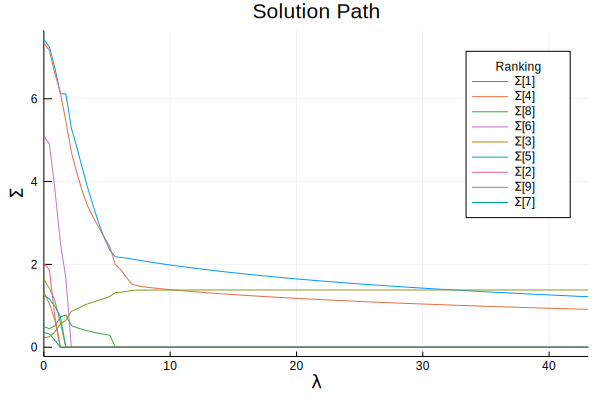

In [31]:
plotsolpath(Σ̂path, λpath; legendout=false)

The above ranking could have been obtained by using function `rankvarcomps` as well:

In [33]:
ranking, zerovarcomps = rankvarcomps(Σ̂path)

([1, 4, 8, 6, 3, 5, 2, 9, 7], [10])

Note that output includes two vectors. The first vector `nonzerovarcomps` displays indices of variance components in the order they entered the solution path; the second vector `zerovarcomps` shows indices of those that are zero (except when $\lambda=0)$ and residual variance component, in no particular order. 